In [1]:
# to disable warning messages.
import warnings
warnings.filterwarnings('ignore')

In [2]:
#
import Omics.OmicsData as OD
import os
#import docx

import seaborn as sns; sns.set()

import hypertools as hyp
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (6, 6)
plt.grid(True)
%matplotlib notebook
RS = 20170628

import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, FeatureAgglomeration
from sklearn.metrics import silhouette_score, calinski_harabaz_score

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, IsolationForest
from sklearn.tree  import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

/Users/jonrob/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Run this cell if there are OD import errors, or there has been an update in OmicsData.py

In [ ]:
#import importlib
#importlib.reload(OD)



#### To see the value of multiple statements within a cell at once.

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Select a cancer type and class variable for Analysis. That is, choose a value for the variables 'CancerType' and 'ClassVar' below.  We get samples related to the chosen cancer type from 'CancerDataStore' in the data frame 'dfCancerType'. 

In [4]:
# Following is the list of all cancer types. Choose the ones that you want to perform the analysis on. 
#'TCGA-ACC', 'TCGA-BLCA', 'TCGA-BRCA', 'TCGA-CESC', 'TCGA-CHOL', 'TCGA-COAD', 'TCGA-DLBC', 
#'TCGA-ESCA', 'TCGA-GBM', 'TCGA-HNSC', 'TCGA-KICH', 'TCGA-KIRC', 'TCGA-KIRP', 'TCGA-LGG', 
#'TCGA-LIHC', 'TCGA-LUAD', 'TCGA-LUSC', 'TCGA-MESO', 'TCGA-OV', 'TCGA-PAAD', 'TCGA-PCPG', 
#'TCGA-PRAD', 'TCGA-READ', 'TCGA-SARC', 'TCGA-SKCM', 'TCGA-STAD', 'TCGA-TGCT', 'TCGA-THCA', 
#'TCGA-THYM', 'TCGA-UCEC', 'TCGA-UCS', 'TCGA-UVM']
CancerType = 'TCGA-KIRC'

# Chose one of the following as class variable.
# CancerStatus TumorStage TumorStageMerged Race Gender
ClassVar = 'TumorStage'

CancerDataStore = pd.HDFStore('data/CancerDataStore.h5')
dfCancerType = CancerDataStore.get(CancerType.split('-')[1])
CancerDataStore.close()
#print("Number of samples in the dataset before removing missing values: {0}".format(dfCancerType.shape[0])) 
#OD.printNaNs(dfCancerType)
print("Cancer Type: " + '\033[1m{:10s}\033[0m'.format(CancerType))
totalsamples = dfCancerType.shape[0]
#print("Number of samples in the dataset: {0}".format(totalsamples)) 
dfCancerType = OD.dropNaNs(dfCancerType, ClassVar)

if totalsamples > dfCancerType.shape[0]:
    print("Number of samples in the dataset after removing missing values: {0}".format(dfCancerType.shape[0]))

Cancer Type: TCGA-KIRC 

********************************************************************
Number of samples in the dataset: 611
********************************************************************
There are no samples with missing values!


#### Now, we filter the data based on the class variable we're interested in. Only 'Primary solid Tumor' samples are used, unless the class variable is CancerStatus.

In [5]:

dfAnalysis = dfCancerType.copy()
ClassVarLevelsFreqTab, ClassVarLevelsSorted = OD.returnVarLevelsSorted(dfAnalysis,ClassVar)
totalsamples = dfAnalysis.shape[0]
print("Cancer Type: " + '\033[1m{:10s}\033[0m'.format(CancerType))
print("Variable for analysis: " + '\033[1m{:10s}\033[0m'.format(ClassVar))
print("Total samples: " + '\033[1m{:d}\033[0m'.format(totalsamples))
ClassVarLevelsFreqTab

#print("{:_<17} : {:5d}".format('Total samples',ClassVarLevelsFreqTab.Frequency.sum()))

# Keep samples related to Tumor cells only if CancerStatus is not the class var. 
if ClassVar != 'CancerStatus':
    toKeep = ['Primary solid Tumor']
    print("\nKeeping samples concerning 'Primary solid Tumor' only.")
    dfAnalysis = OD.FilterLevels(dfAnalysis, 'CancerStatus', toKeep, printStats='no')

# if previous if has been True, we need to print updated stats    
if totalsamples > dfAnalysis.shape[0]:
    print("Updated, number of samples in the dataset:" + '\033[1m{:d}\033[0m'.format(dfAnalysis.shape[0])) 
    ClassVarLevelsFreqTab, ClassVarLevelsSorted = OD.returnVarLevelsSorted(dfAnalysis,ClassVar)
    ClassVarLevelsFreqTab
    
# sometimes ClassVar is'not reported' for some samples. We need to remove those as well.
# and print the updated stats and also update the dataset.
if 'not reported' in ClassVarLevelsSorted:
    notReported = sum(ClassVarLevelsFreqTab[ClassVarLevelsFreqTab[ClassVar] == 'not reported']['Frequency'])
    print("\nRemoved {0} samples where '{1}' is 'not reported'.".format(notReported, ClassVar))
    dfAnalysis.drop(dfAnalysis.index[dfAnalysis[ClassVar] == 'not reported'], inplace= True)
    print("Now, there are " + '\033[1m' + str(dfAnalysis.shape[0]) + '\033[0m' + " samples in the dataset.")#.format(dfAnalysis.shape[0]))
    ClassVarLevelsFreqTab, ClassVarLevelsSorted = OD.returnVarLevelsSorted(dfAnalysis,ClassVar)
    ClassVarLevelsFreqTab
    
print("\nVarLevelsToKeep = {0}".format(ClassVarLevelsSorted))
print("\nThese two levels of '{0}' will be kept for further analysis: {1}".format(ClassVar, ClassVarLevelsSorted[0:2]))
VarLevelsToKeep = ClassVarLevelsSorted[0:2]
    

Cancer Type: TCGA-KIRC 
Variable for analysis: TumorStage
Total samples: 611


,TumorStage,Frequency
0,stage i,297
1,stage iii,139
2,stage iv,102
3,stage ii,70
4,not reported,3



Keeping samples concerning 'Primary solid Tumor' only.
Updated, number of samples in the dataset:538


,TumorStage,Frequency
0,stage i,271
1,stage iii,123
2,stage iv,82
3,stage ii,59
4,not reported,3



Removed 3 samples where 'TumorStage' is 'not reported'.
Now, there are 535 samples in the dataset.


,TumorStage,Frequency
0,stage i,271
1,stage iii,123
2,stage iv,82
3,stage ii,59



VarLevelsToKeep = ['stage i', 'stage iii', 'stage iv', 'stage ii']

These two levels of 'TumorStage' will be kept for further analysis: ['stage i', 'stage iii']


#### Finally, we keep only top two levels of the ClassVar for further analysis. However, one can select different pairs/sets for the analysis. If so, copy the above VarLevelsToKeep = ... and paste in the cell below. Keep all or remove the values from this list which are not required for further analysis.

In [11]:
# OPTIONAL: specify which levels of the class variable will be used in the analysis. If no levels are specified,
# the two most common levels will automatically be used.
VarLevelsToKeep = ['stage i', 'stage iii']

dfAnalysis_fl = OD.FilterLevels(dfAnalysis, ClassVar, VarLevelsToKeep, printStats='no')

ClassVarLevelsFreqTab, ClassVarLevelsSorted = OD.returnVarLevelsSorted(dfAnalysis_fl,ClassVar)

#print(ClassVarLevelsFreqTab)
print("Cancer Type: " + '\033[1m{:10s}\033[0m'.format(CancerType))
print("Variable for analysis: " + '\033[1m{:10s}\033[0m'.format(ClassVar))
print("Finally, number of samples in the dataset:" + '\033[1m{:d}\033[0m'.format(dfAnalysis_fl.shape[0])) 
print("Samples distribution within the variable levels kept for analysis:") 

ClassVarLevelsFreqTab

# + '\033[1m{:d}\033[0m'.format(dfAnalysis_fl.shape[0]))

dfAnalysis_fl = OD.prepareDF(dfAnalysis_fl, ClassVar)

print("Size of the dataframe: {0}".format(dfAnalysis_fl.shape))

# OPTIONAL: specify whether dimensionality reduction will be applied, and the method used.
dimReduction = False 
numSigCancers = 10
dimRedMethod = 'signifDEgenes' # signifDEgenes numSigCancers

if dimReduction: # step into dim reduction if dimReduction is set to True
    signifDEgenes = pd.read_excel("PSN_genes_signifDE.xlsx")
    signifDECancerTypes = signifDEgenes.columns[3:].tolist()
    signifDECancerTypes = [s.split('_')[1] for s in signifDECancerTypes]
    if CancerType.split('-')[1] in signifDECancerTypes: # Make sure that the selected cancer type exists
        if dimRedMethod == 'numSigCancers':
            signifDEgenes = signifDEgenes.loc[signifDEgenes["num sig cancers"]>=numSigCancers, "gene name"].tolist()
        elif dimRedMethod == 'signifDEgenes':
            signifDEgenes = signifDEgenes.loc[signifDEgenes["Padj_" + CancerType.split('-')[1]]<=0.01, "gene name"].tolist()
        signifDEgenes.insert(0,ClassVar)
        dfAnalysis_fl = dfAnalysis_fl[signifDEgenes]
        print("Size of the dataframe after filtering signifDEgenes: {0}".format(dfAnalysis_fl.shape))
        dfAnalysis_fl_cd = dfAnalysis_fl
    else:
        print("Dim reduction cannot be performed because the cancer type '{0}' does not have paired samples.")
else: # proceed to the normal step if dim reduction is not desired.
    # Look at the list LowCountGene, these are the genes which will be removed.
    # The percentile can be adjusted by changing the "Level=X" input, where X = percentile.
    data_stats, LowCountGene = OD.GeneExpression(dfAnalysis_fl,Level=2)
    print("********************************************************************")
    print("Following {0} genes are removed because their expression values lie in the lower {1} percentile of the entire set.".format(len(LowCountGene),2))
    print(LowCountGene)
    # Remove low count genes
    dfAnalysis_fl_cd = OD.CleanData(dfAnalysis_fl,2)
    print("\nSize of the dataframe after filtering low count genes: {0}".format(dfAnalysis_fl_cd.shape))


# Perform label encoding for the ClassVar and scale data using log transform
dfAnalysis_fl_cd, ClassVarEncOrder = OD.mapClassVar(dfAnalysis_fl_cd,ClassVar)
X, y = OD.fitLogTransform(dfAnalysis_fl_cd)

Cancer Type: TCGA-KIRC 
Variable for analysis: TumorStage
Finally, number of samples in the dataset:394
Samples distribution within the variable levels kept for analysis:


,TumorStage,Frequency
0,stage i,271
1,stage iii,123


Size of the dataframe: (394, 576)
********************************************************************
Following 12 genes are removed because their expression values lie in the lower 2 percentile of the entire set.
['GALNTL5' 'ATXN3L' 'LMAN1L' 'CRYAA' 'DNAJC5G' 'TBC1D21' 'PDILT' 'FAM71B'
 'GALNTL6' 'UBQLN3' 'MGAT4C' 'GLT6D1']

Size of the dataframe after filtering low count genes: (394, 564)

***************************************************************
Following label encoding has been assigned to the values of TumorStage.
{0: 'stage i', 1: 'stage iii'}

***************************************************************


<IPython.core.display.Javascript object>


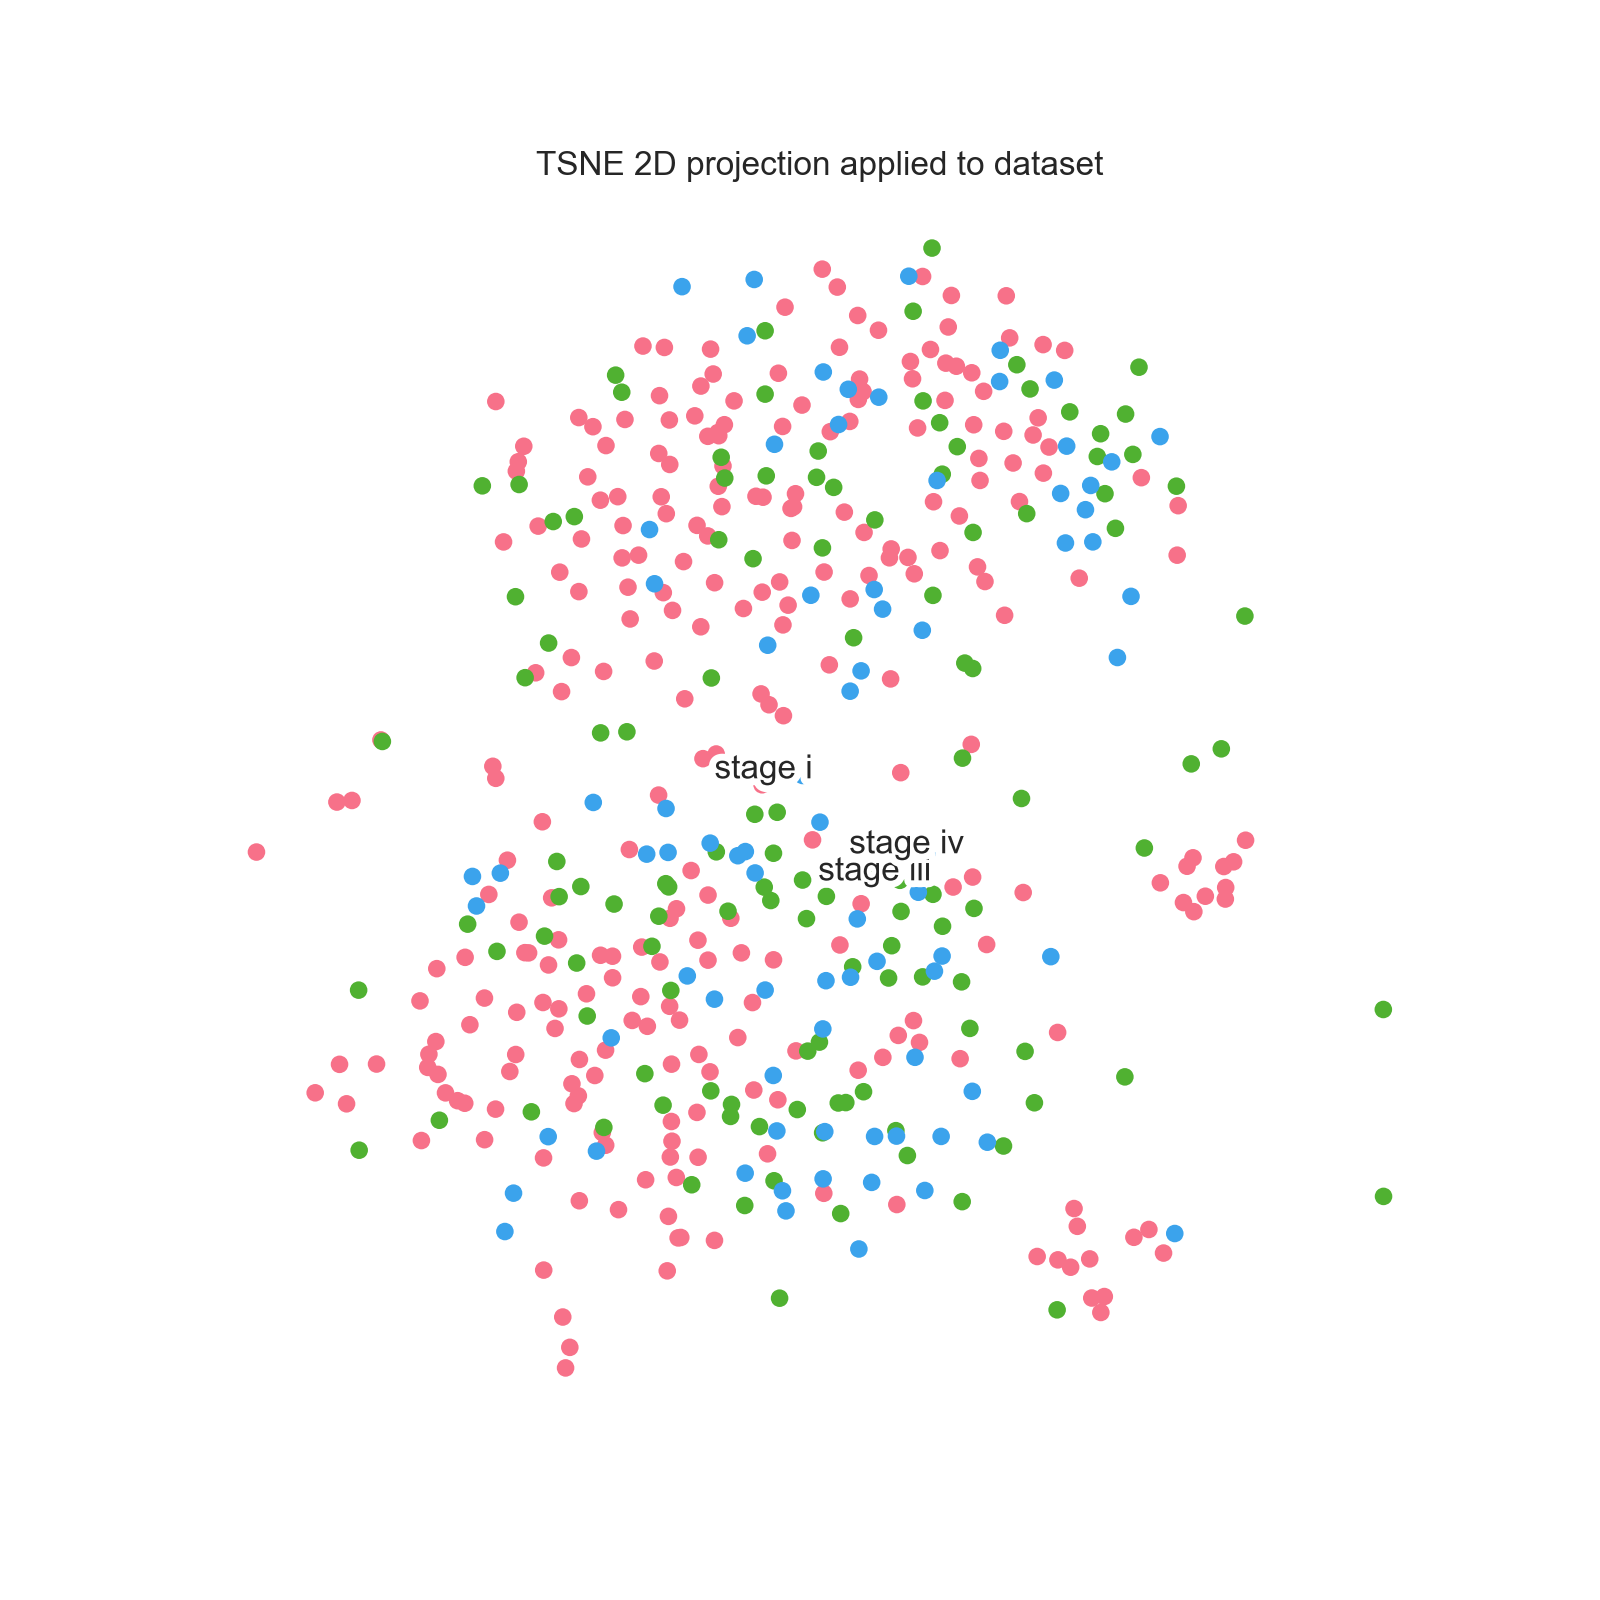

<IPython.core.display.Javascript object>


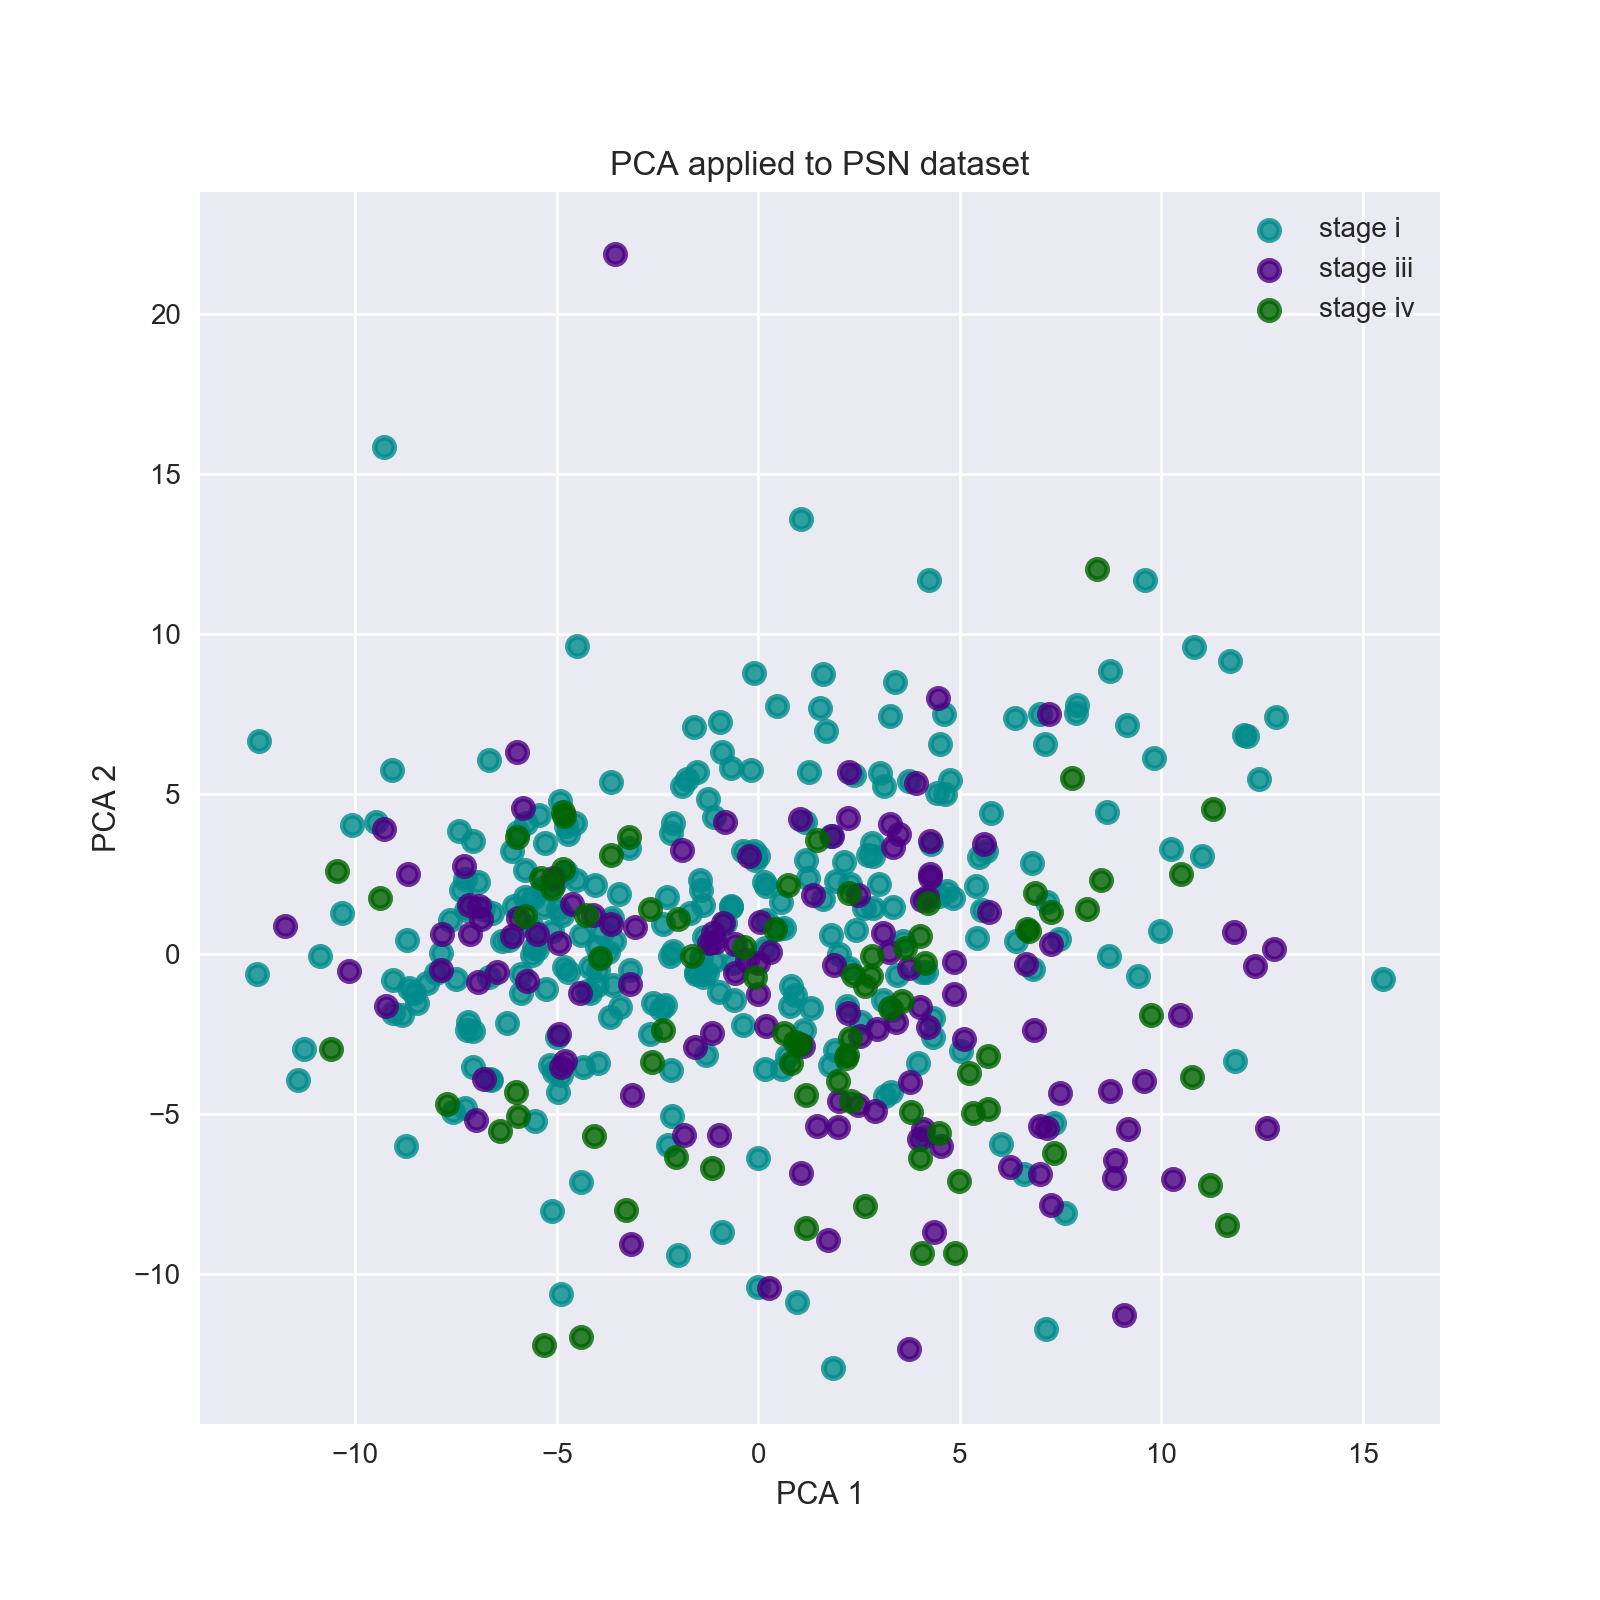

<IPython.core.display.Javascript object>


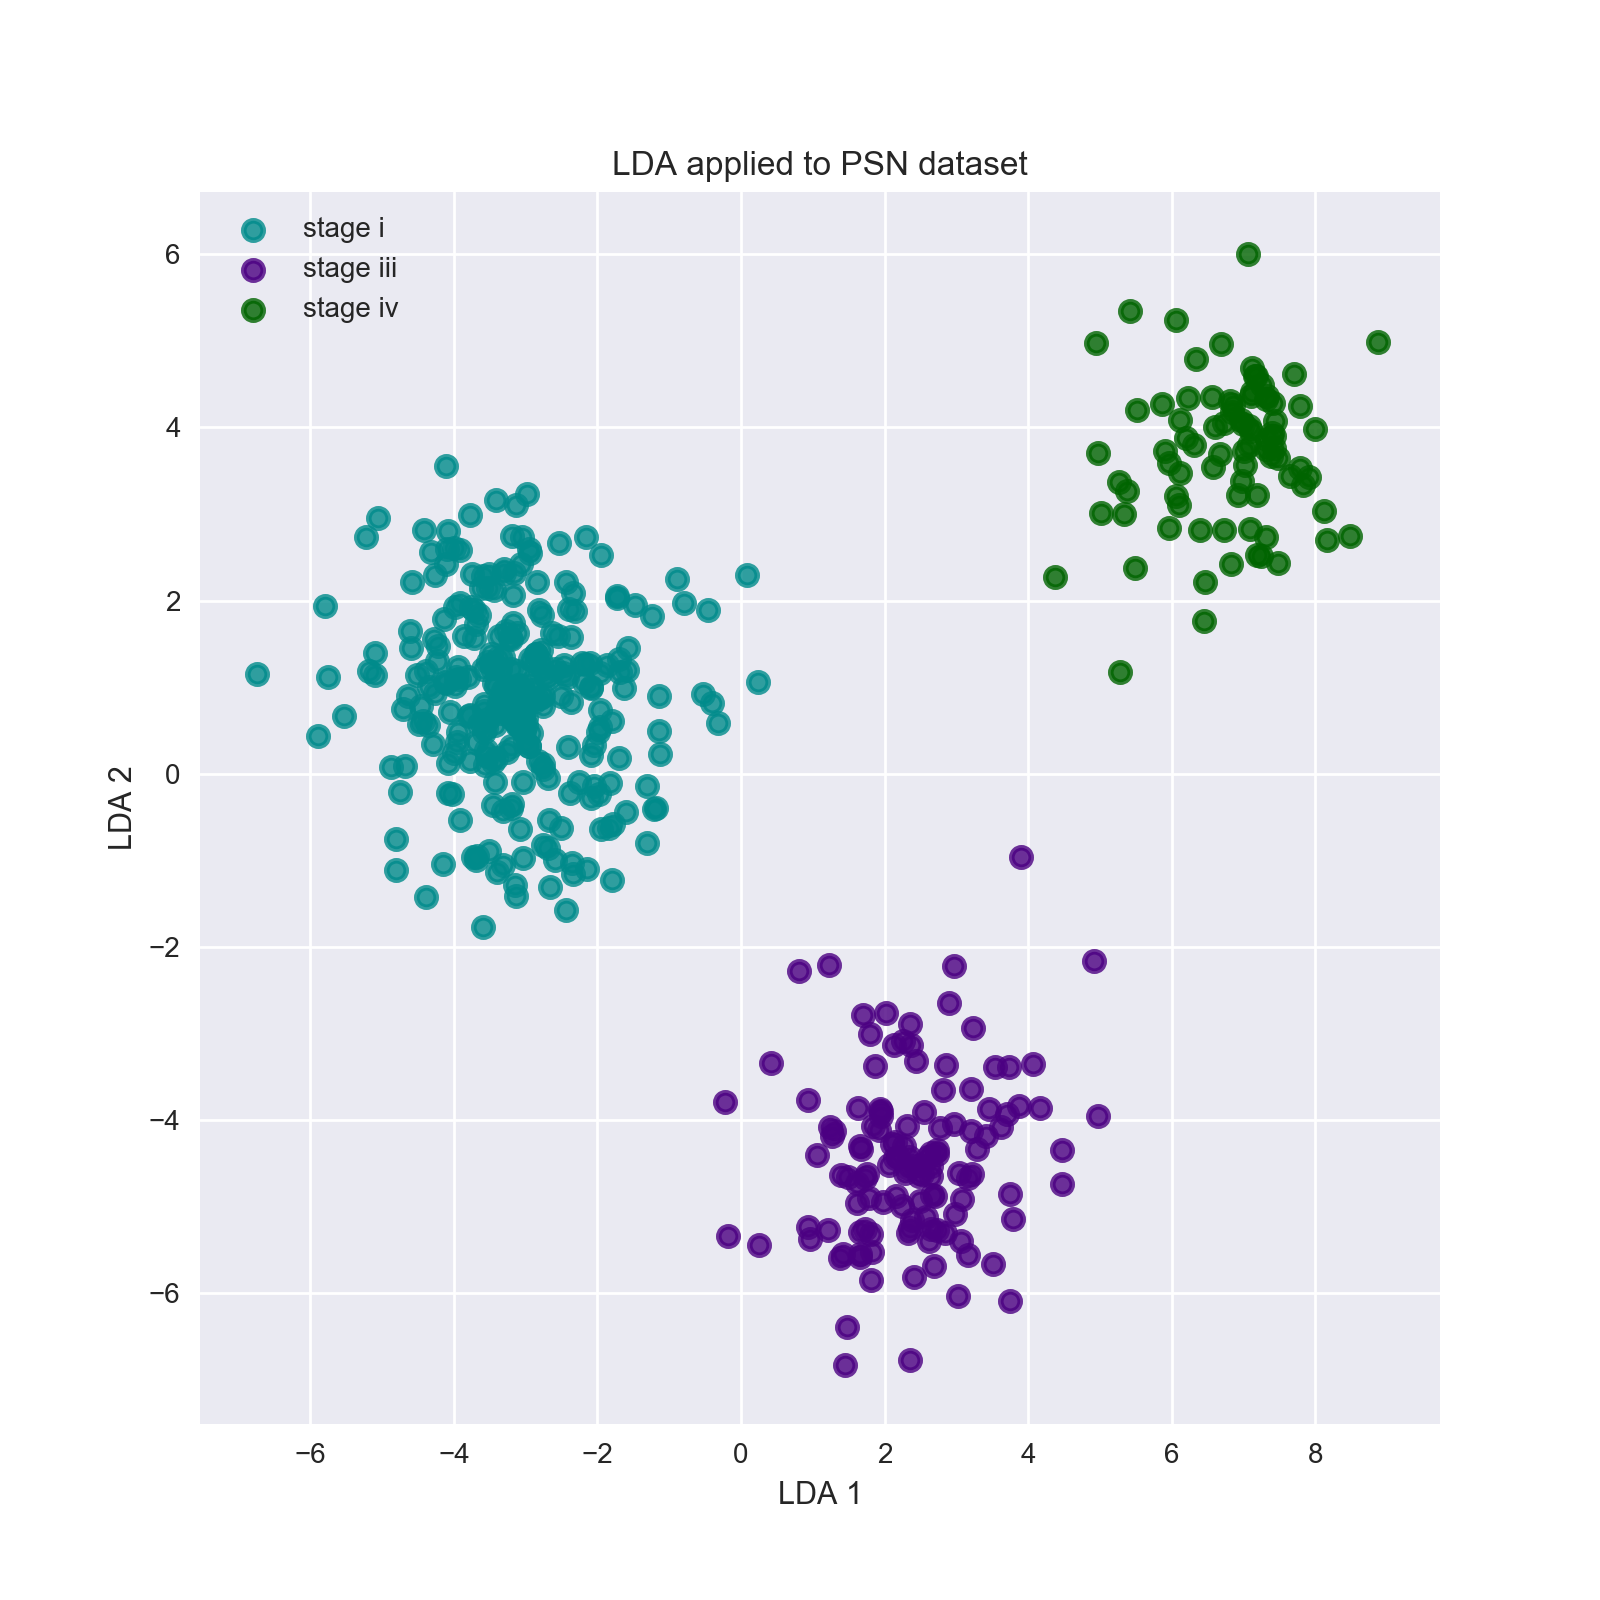

In [9]:
#Now let's run the t-SNE, PCA and LDA algorithms on the dataset.
tsneProj2D = TSNE(random_state=RS, n_components=2).fit_transform(X)
OD.tSNEscatter(tsneProj2D, y, ClassVarEncOrder, len(VarLevelsToKeep))
OD.plotPCA(X, y, 2, VarLevelsToKeep, save=False)
if len(VarLevelsToKeep) >2:
    OD.plotLDA(X, y, 2, VarLevelsToKeep, save=False)
else:
    classifier = LinearDiscriminantAnalysis()
    mod_name = "LDA"
    CV = 'Validation: SKF'
    shuffle = True
    OD.ROCanalysis(mod_name, CV, classifier, X, y, shuffle)

In [ ]:
#Now let's run the t-SNE, PCA and LDA algorithms on the dataset after removing outliers.

Xcleaned = np.append(XclustInly0, XclustInly1, axis=0)
ycleaned = np.append(y0,y1, axis=0)
tsneProj2D = TSNE(random_state=RS, n_components=2).fit_transform(Xcleaned)
OD.tSNEscatter(tsneProj2D, ycleaned, ClassVarEncOrder, len(VarLevelsToKeep))
OD.plotPCA(Xcleaned, ycleaned, 2, VarLevelsToKeep, save=False)
if len(VarLevelsToKeep) >2:
    OD.plotLDA(Xcleaned, ycleaned, 2, VarLevelsToKeep, save=False)
#else:
#    classifier = LinearDiscriminantAnalysis()
#    mod_name = "LDA"
#    CV = 'Validation: SKF'
#    shuffle = True
#    OD.ROCanalysis(mod_name, CV, classifier, Xcleaned, ycleaned, shuffle)

<IPython.core.display.Javascript object>


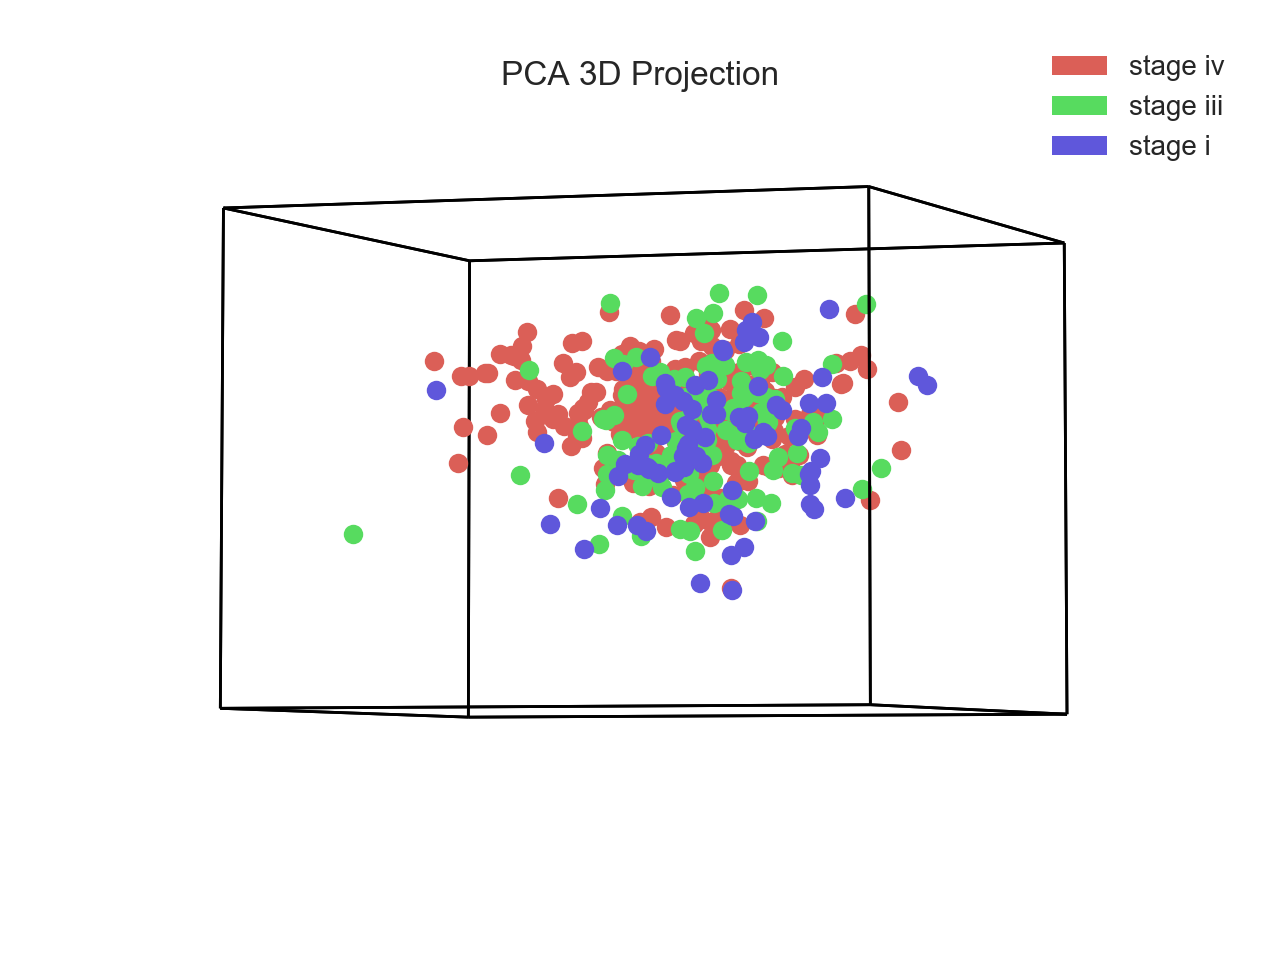

<IPython.core.display.Javascript object>


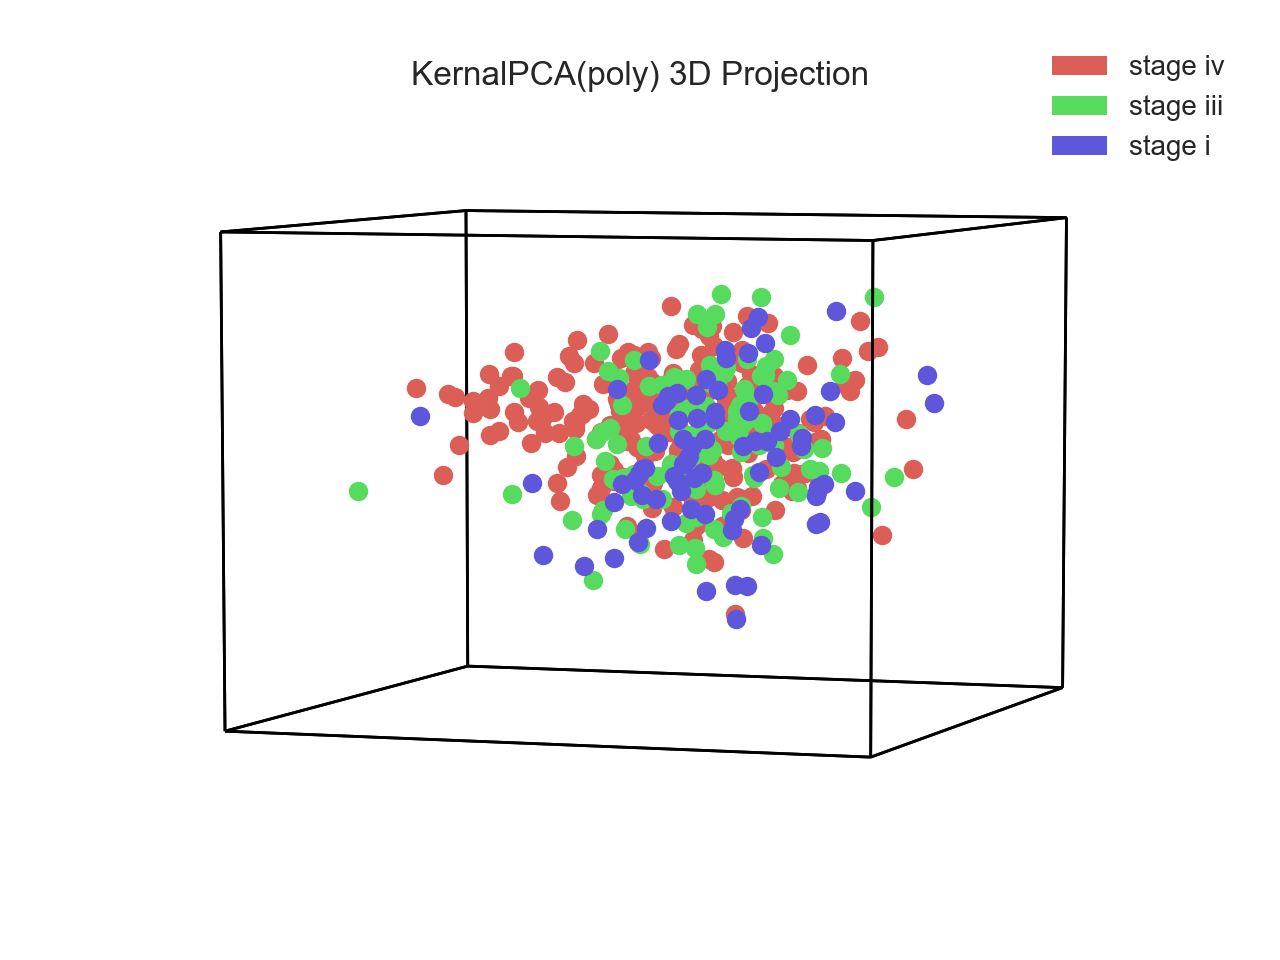

<IPython.core.display.Javascript object>


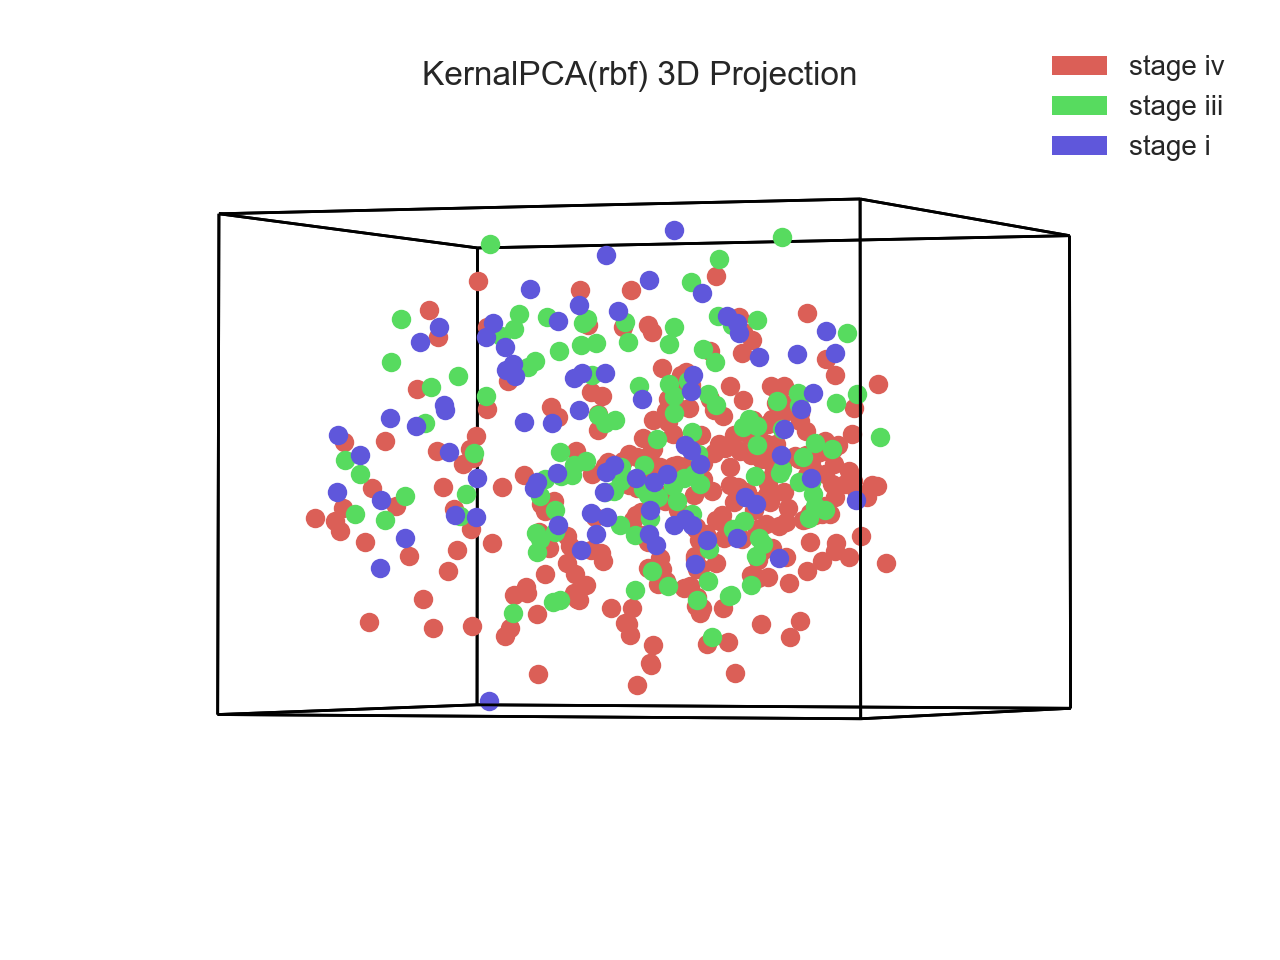

<IPython.core.display.Javascript object>


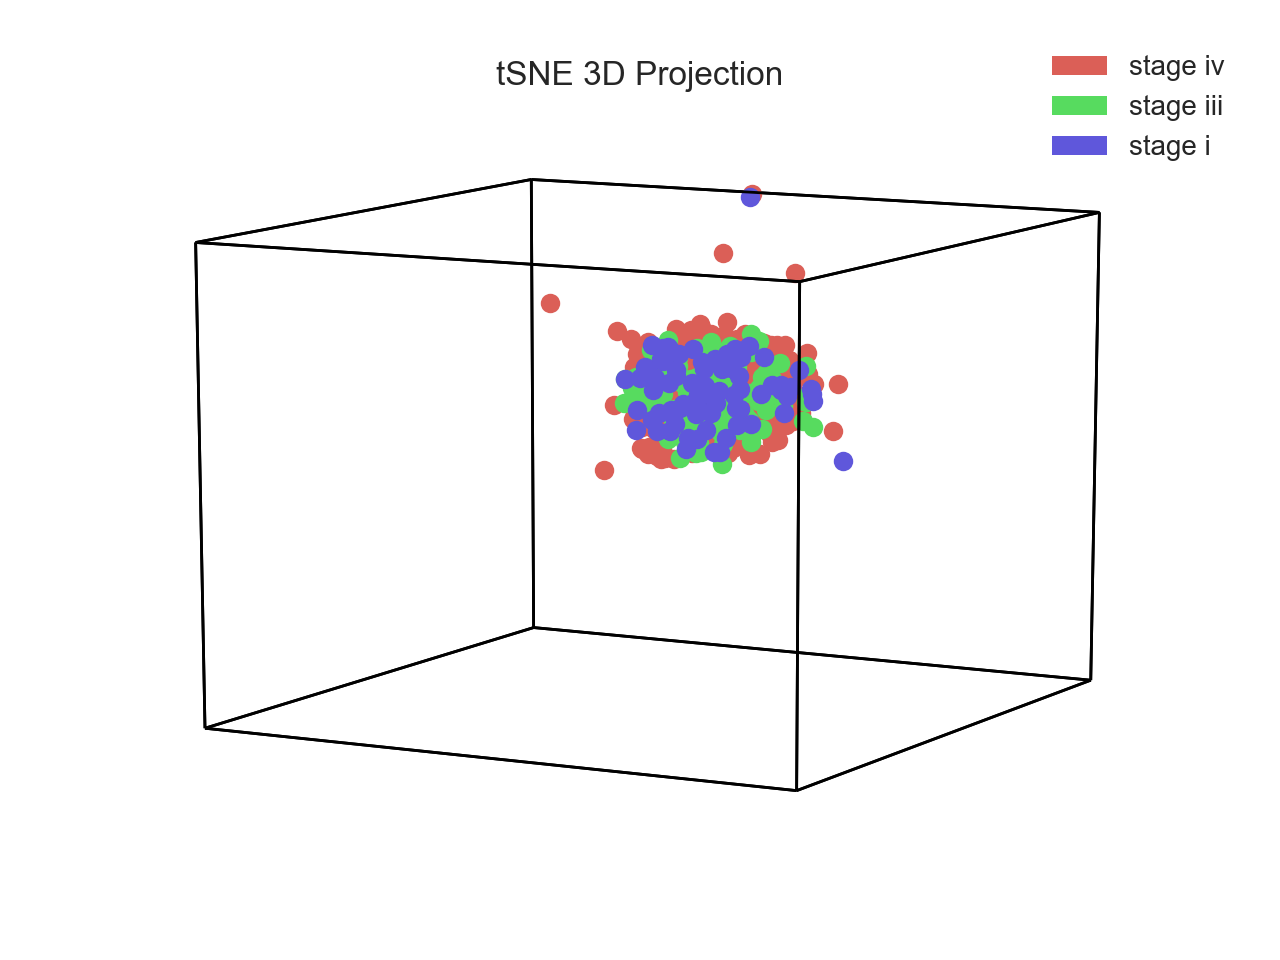

<IPython.core.display.Javascript object>


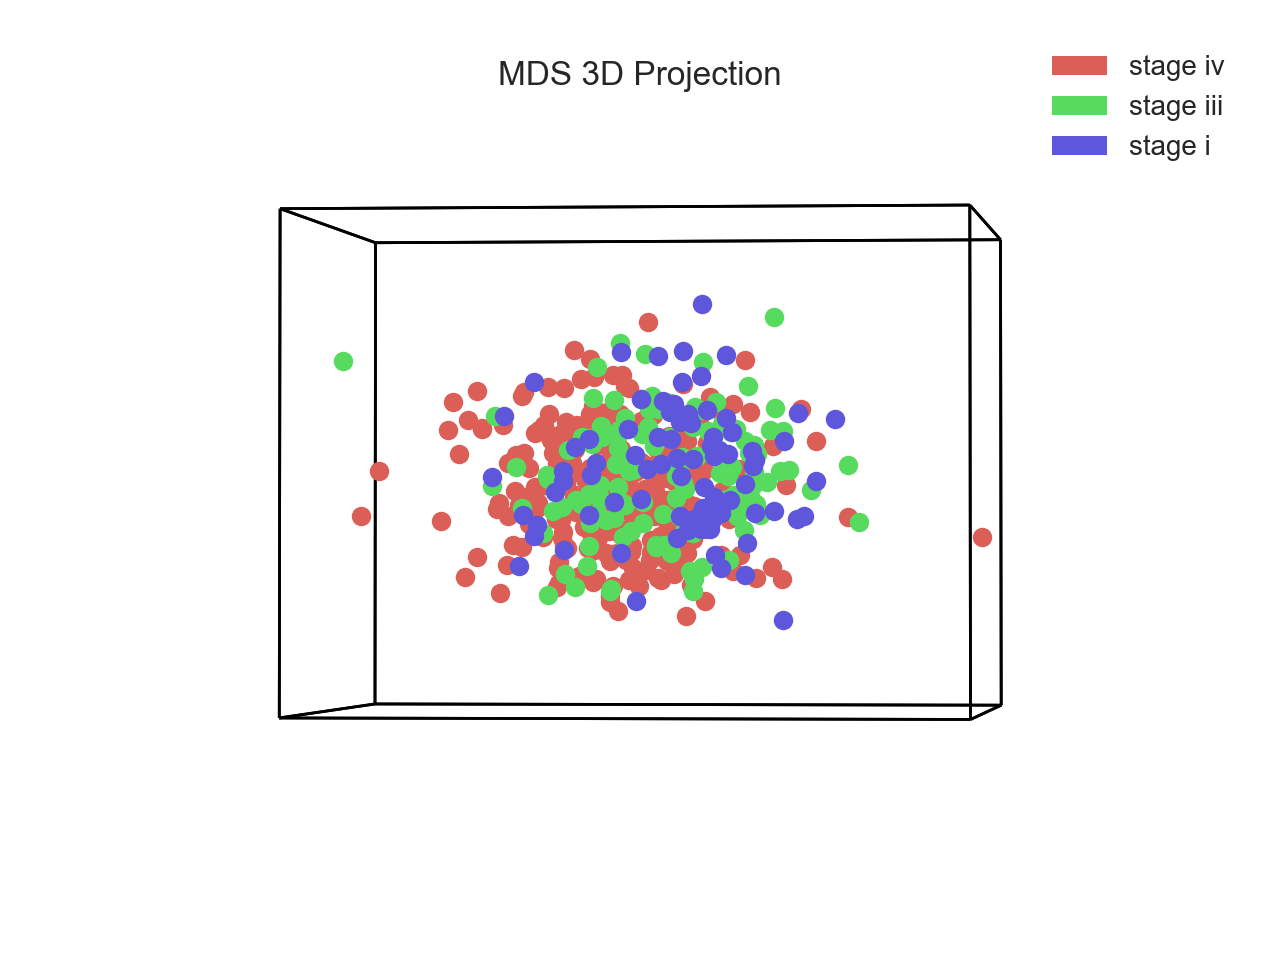

In [10]:
# Now let's use hypertools to create 3D plots using different dim reduction techniques.

classLabels = dfAnalysis_fl[ClassVar]
hypPCA = hyp.plot(X,'o', group=classLabels, legend=list(set(classLabels)), title="PCA 3D Projection")#, explore=True)#, animate=True ) #normalize='across')

hypKernalPCA = hyp.plot(X,'o', model='KernelPCA', model_params= {'kernel':"poly"}, group=classLabels, legend=list(set(classLabels)), title="KernalPCA(poly) 3D Projection")#, explore=True)#, animate=True ) #normalize='across')

hypKernalPCA = hyp.plot(X,'o', model='KernelPCA', model_params= {'kernel':"rbf"}, group=classLabels, legend=list(set(classLabels)), title="KernalPCA(rbf) 3D Projection")#, explore=True)#, animate=True ) #normalize='across')
#, 'fit_inverse_transform': True, 'gamma' : 1
#hypKernalPCA = hyp.plot(X,'o', reduce={'model': 'KernelPCA', 'params': {'kernel':"rbf", 'fit_inverse_transform': True, 'gamma' : 10}}, group=classLabels, legend=list(set(classLabels)), title="KernalPCA 3D Projection")#, explore=True)#, animate=True ) #normalize='across')

#tsneProj3D = TSNE(random_state=RS, n_components=3).fit_transform(X)
#hypTSNE-self = hyp.plot(tsneProj3D,'o', group=classLabels, legend=list(set(classLabels)), title="tSNE-self 3D Projection")
hypTSNE = hyp.plot(X,'o', model='TSNE', group=classLabels, legend=list(set(classLabels)), title="tSNE 3D Projection")#, explore=True)
#hypFastICA = hyp.plot(X,'o', model='FastICA', group=classLabels, legend=list(set(classLabels)), title="FastICA 3D Projection")#, explore=True)
hypMDS = hyp.plot(X,'o', model='MDS', group=classLabels, legend=list(set(classLabels)), title="MDS 3D Projection")#, explore=True)



In [12]:
models = [#DecisionTreeClassifier(random_state=RS), # 
          ExtraTreesClassifier(n_estimators=200, random_state=RS), # 0
          RandomForestClassifier(n_estimators=200, random_state=RS), # 1
          AdaBoostClassifier(n_estimators=200), # 2
          xgb.XGBClassifier(), # 3
          LinearDiscriminantAnalysis(), # 4
          RidgeClassifier(), # 5
          KNeighborsClassifier(20), # 6
          svm.SVC(kernel='linear'), # 7
          svm.SVC(kernel='rbf', C=5) # 8  
         ]

In [13]:
# Run models for crossvalidated average score of accuracy
CV = 'Validation: SKF'
shuffle = True
scoring = 'accuracy'
folds = 10
#dfCVscoresAUC = OD.CVScorer([svm.NuSVC()], CV, X, y, scoring, shuffle)
dfCVscoresAUC = OD.CVScorer(models, CV, X, y, scoring, shuffle, folds)
#dfCVscoresAUC = OD.CVScorer([models[i] for i in [4,5]], CV, X, y, scoring, shuffle)
print("Cancer Type: ", CancerType)
dfCVscoresAUC

Cancer Type:  TCGA-KIRC


,Model,Scoring,Score,CI-lower,CI-high
0,ExtraTreesClassifier,accuracy,0.730613,0.647543,0.813683
1,RandomForestClassifier,accuracy,0.743494,0.629053,0.857936
2,AdaBoostClassifier,accuracy,0.690597,0.541437,0.839758
3,XGBClassifier,accuracy,0.719361,0.555797,0.882924
4,LinearDiscriminantAnalysis,accuracy,0.670338,0.570563,0.770112
5,RidgeClassifier,accuracy,0.634511,0.519806,0.749216
6,KNeighborsClassifier,accuracy,0.720796,0.645276,0.796316
7,SVC,accuracy,0.687780,0.535736,0.839823
8,SVC,accuracy,0.751315,0.621251,0.881379


#### ROC analysis only feasible when ClassVar has only two possible values. When analyzing more than two levels for ClassVar, don't run this cell 

In [14]:
# Run models for crossvalidated average score of area under the roc curve
if len(VarLevelsToKeep) == 2:
    scoring = 'roc_auc'
    dfCVscoresROC = OD.CVScorer(models, CV, X, y, scoring, shuffle, folds)
    #dfCVscoresROC = OD.CVScorer([models[i] for i in [8, 9]], CV, X, y, scoring, shuffle)
    print("Cancer Type: ", CancerType)
    dfCVscoresROC
else:
    print("Skipping CV analysis using area under the ROC curve. This is possible for binary problems only.")
        

Cancer Type:  TCGA-KIRC


,Model,Scoring,Score,CI-lower,CI-high
0,ExtraTreesClassifier,roc_auc,0.719238,0.558930,0.879545
1,RandomForestClassifier,roc_auc,0.729701,0.557204,0.902197
2,AdaBoostClassifier,roc_auc,0.631030,0.499489,0.762572
3,XGBClassifier,roc_auc,0.730271,0.608212,0.852329
4,LinearDiscriminantAnalysis,roc_auc,0.709731,0.540001,0.879461
5,RidgeClassifier,roc_auc,0.667189,0.490880,0.843498
6,KNeighborsClassifier,roc_auc,0.693308,0.430451,0.956166
7,SVC,roc_auc,0.717142,0.543147,0.891136
8,SVC,roc_auc,0.740062,0.578459,0.901665


In [17]:
dfAnalysisOriginal = pd.DataFrame(np.c_[y,X], 
                                    columns=dfAnalysis_fl_cd.columns)
dfAnalysisOriginal[ClassVar] = dfAnalysisOriginal[ClassVar].astype(int)


In [ ]:
import os

In [ ]:
print("Writing dataset and CV analysis results to a directory named:{0}".format(CancerType))
os.makedirs(CancerType , exist_ok=True)

writer = pd.ExcelWriter(CancerType + '/' + CancerType + '-' + ClassVar + 'Results.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
#dfRanks.to_excel(writer, sheet_name='GenesRanking', index=False, float_format='%.10f')

dfCVscoresAUC.to_excel(writer, sheet_name='Accuracy', index=False, float_format='%.10f')
dfCVscoresAUC.to_csv(CancerType + '/' + CancerType + '-' + ClassVar + 'Accuracy.csv', index=False)

if len(VarLevelsToKeep) == 2:
    dfCVscoresROC.to_excel(writer, sheet_name='AreaUnderROC', index=False, float_format='%.10f')
    dfCVscoresROC.to_csv(CancerType + '/' + CancerType + '-' + ClassVar + 'AreaUnderROC.csv', index=False)

writer.save()

#dfRanks.to_csv(CancerType + '/' + CancerType + '-' + ClassVar + 'GenesRanking.csv', index=False)
dfAnalysisOriginal.to_csv(CancerType + '/' + CancerType + '-' + ClassVar + 'OriginalData.csv', index=False)

print("Done!")


#### Perform clustering analysis. We filter out samples of the same type (like tumor or normal ones) by providing the corresponding code from the label encoding performed earliear. 

In [ ]:
Xclust = X[y==0] # {0: 'Primary solid Tumor', 1: 'Solid Tissue Normal'}
y0 = y[y==0]
means = Xclust.mean(axis=0)
meansSorted =np.sort(means)
medians = np.median(Xclust, axis=0)
mediansSorted = np.sort(medians)

plt.figure()
axOriginal =sns.heatmap(Xclust, cmap=plt.cm.Blues, cbar_kws={'label': 'Original dataset'} );
#axOriginal.plot()
#sns.show()
plt.figure()
XclustSortedMeans = Xclust[:,np.argsort(means)]
axMeans = sns.heatmap(XclustSortedMeans, cmap=plt.cm.Blues, cbar_kws={'label': 'Dataset sorted wrt column means'} );
#axMeans.plot()
#plt.show()

plt.figure()
XclustSortedMedians = Xclust[:,np.argsort(medians)]
axColumns = sns.heatmap(XclustSortedMedians, cmap=plt.cm.Blues,
                        cbar_kws={'label': 'Dataset sorted wrt column medians'} );

In [ ]:

isoForest = IsolationForest(n_estimators=1000, contamination=0.40) # you can chose a different value
isoForest.fit(Xclust)
outlierIsoFor = isoForest.predict(Xclust)
pd.DataFrame(outlierIsoFor)[0].value_counts()
#outlierTF = outlier == 1
#dftesting_clean =dftesting[outlierTF]
XclustInl = Xclust[outlierIsoFor == 1]

XclustInly0 = XclustInl.copy()
temp = y0[outlierIsoFor == 1]
y0 = temp

In [ ]:
plt.figure()
plt.scatter(x= np.arange(len(meansSorted)), y=meansSorted);
plt.title("Sorted values of column's means");

meansXclustInl = XclustInl.mean(axis=0)
meansSortedXclustInl =np.sort(meansXclustInl)
mediansXclustInl = np.median(Xclust, axis=0)
mediansSortedXclustInl = np.sort(mediansXclustInl)
plt.figure()
plt.scatter(x= np.arange(len(meansSortedXclustInl)), y=meansSortedXclustInl);
plt.title("Sorted values of column's means after outliers removal");

plt.figure()
plt.scatter(x=np.arange(len(mediansSorted)), y=mediansSorted);
plt.title("Sorted values of column's medians");

plt.figure()
plt.scatter(x=np.arange(len(mediansSortedXclustInl)), y=mediansSortedXclustInl);
plt.title("Sorted values of column's medians after outliers removal");



In [ ]:
XclustInlOut = np.append(XclustInl, Xclust[outlierIsoFor == -1], axis=0)

plt.figure()
axOriginal =sns.heatmap(Xclust, cmap=plt.cm.Blues, cbar_kws={'label': 'Original dataset'} );

plt.figure()
axOriginal =sns.heatmap(XclustInlOut, cmap=plt.cm.Blues, cbar_kws={'label': 'Original dataset, outliers pushed down'} );


In [ ]:
Ks = range(2, 30)
km = [KMeans(n_clusters=i) for i in Ks]
score = [km[i].fit(Xclust.T).score(Xclust.T) for i in range(len(km))]

plt.figure()#figsize=(5,5))
plt.title("Elbow method using original data to determine optimal number of clusters (k)")
plt.scatter(x=Ks, y=score, data=score);

Ks = range(2, 30)
km = [KMeans(n_clusters=i) for i in Ks]
score = [km[i].fit(XclustInl.T).score(XclustInl.T) for i in range(len(km))]

plt.figure() #figsize=(5,5))
plt.title("Elbow method using cleaned data to determine optimal number of clusters (k)")
plt.scatter(x=Ks, y=score, data=score);



In [ ]:
Ks = range(2, 30)
fagg = [FeatureAgglomeration(n_clusters=i, linkage='ward').fit(Xclust) for i in Ks]
scoreCH = [calinski_harabaz_score(Xclust.T, fagg[i].labels_) for i in range(len(fagg)) ]
scoreSH = [silhouette_score(Xclust.T, fagg[i].labels_, metric='euclidean') for i in range(len(fagg)) ]
plt.figure() #figsize=(5,5))
plt.title("Average Calinski Harabaz score for different k")
plt.scatter(x=Ks, y=scoreCH, data=scoreCH);
plt.figure() #figsize=(5,5))
plt.title("Average Silhouette score for different k")
plt.scatter(x=Ks, y=scoreSH, data=scoreSH);

In [ ]:
dfClustersY0 = pd.DataFrame(index=dfAnalysis_fl_cd.columns[1:])
dfClustersY0cd = pd.DataFrame(index=dfAnalysis_fl_cd.columns[1:])

def heatmaps():
    
    plt.figure()
    axXclust = sns.heatmap(Xclust[:,np.argsort(aggloXclust.labels_)], cmap=plt.cm.Blues, cbar_kws={'label': 'Genes rearranged to show clusters (' + str(n) + ')' } )

    plt.figure()
    axXclustInlOut = sns.heatmap(XclustInlOut[:,np.argsort(aggloXclust.labels_)], cmap=plt.cm.Blues, cbar_kws={'label': 'Genes rearranged to show clusters (' + str(n) + '),' +  '\n inconsistent samples pushed down'} );

    plt.figure()
    axXclustInl = sns.heatmap(XclustInl[:,np.argsort(aggloXclust.labels_)], cmap=plt.cm.Blues, cbar_kws={'label': 'Genes rearranged to show clusters (' + str(n) + '),' + '\n inconsistent samples discarded'} );
    
    plt.figure()
    axXclustReduced = sns.heatmap(XclustReduced, cmap=plt.cm.Blues,  cbar_kws={'label': 'Centers of clusters (' + str(n) + ')' } );

    plt.figure()
    axXclustInl2 = sns.heatmap(XclustInl[:,np.argsort(aggloXclustInl.labels_)], cmap=plt.cm.Blues, cbar_kws={'label': 'Genes rearranged to show clusters (' + str(n) + '),' + '\n learned on cleaned data'} );
    
    plt.figure()
    axXclustInlReduced = sns.heatmap(XclustInlReduced, cmap=plt.cm.Blues,  cbar_kws={'label': 'Centers of clusters (' + str(n) + ') of cleaned data' } );

for n in range(4,8):
    aggloXclust =  FeatureAgglomeration(n_clusters=n, linkage='ward').fit(Xclust)
    XclustReduced = aggloXclust.transform(Xclust)
    dfClustersY0["C-" + str(n)] = aggloXclust.labels_

    aggloXclustInl =  FeatureAgglomeration(n_clusters=n, linkage='ward').fit(XclustInl)
    XclustInlReduced = aggloXclustInl.transform(XclustInl)
    dfClustersY0cd["C-" + str(n)] = aggloXclustInl.labels_

    #    aggloXclust =  KMeans(n_clusters=n).fit(Xclust.T)
#    XclustReduced = aggloXclust.transform(Xclust.T)
    heatmaps()



#### We filter out samples of the same type (like tumor or normal ones) by providing the corresponding code from the label encoding performed earliear. 

In [ ]:
Xclust = X[y==1] # {0: 'Primary solid Tumor', 1: 'Solid Tissue Normal'}
y1 = y[y==1]
means = Xclust.mean(axis=0)
meansSorted =np.sort(means)
medians = np.median(Xclust, axis=0)
mediansSorted = np.sort(medians)

plt.figure()
axOriginal =sns.heatmap(Xclust, cmap=plt.cm.Blues, cbar_kws={'label': 'Original dataset'} );
#axOriginal.plot()
#sns.show()
plt.figure()
XclustSortedMeans = Xclust[:,np.argsort(means)]
axMeans = sns.heatmap(XclustSortedMeans, cmap=plt.cm.Blues, cbar_kws={'label': 'Dataset sorted wrt column means'} );
#axMeans.plot()
#plt.show()

plt.figure()
XclustSortedMedians = Xclust[:,np.argsort(medians)]
axColumns = sns.heatmap(XclustSortedMedians, cmap=plt.cm.Blues,
                        cbar_kws={'label': 'Dataset sorted wrt column medians'} );

In [ ]:

isoForest = IsolationForest(n_estimators=1000, contamination=0.20)
isoForest.fit(Xclust)
outlierIsoFor = isoForest.predict(Xclust)
pd.DataFrame(outlierIsoFor)[0].value_counts()
#outlierTF = outlier == 1
#dftesting_clean =dftesting[outlierTF]
XclustInl = Xclust[outlierIsoFor == 1]

XclustInly1 = XclustInl.copy()
temp = y1[outlierIsoFor == 1]
y1 = temp


In [ ]:
plt.figure()
plt.scatter(x= np.arange(len(meansSorted)), y=meansSorted);
plt.title("Sorted values of column's means");

meansXclustInl = XclustInl.mean(axis=0)
meansSortedXclustInl =np.sort(meansXclustInl)
mediansXclustInl = np.median(Xclust, axis=0)
mediansSortedXclustInl = np.sort(mediansXclustInl)
plt.figure()
plt.scatter(x= np.arange(len(meansSortedXclustInl)), y=meansSortedXclustInl);
plt.title("Sorted values of column's means after outliers removal");

plt.figure()
plt.scatter(x=np.arange(len(mediansSorted)), y=mediansSorted);
plt.title("Sorted values of column's medians");

plt.figure()
plt.scatter(x=np.arange(len(mediansSortedXclustInl)), y=mediansSortedXclustInl);
plt.title("Sorted values of column's medians after outliers removal");



In [ ]:
XclustInlOut = np.append(XclustInl, Xclust[outlierIsoFor == -1], axis=0)

plt.figure()
axOriginal =sns.heatmap(Xclust, cmap=plt.cm.Blues, cbar_kws={'label': 'Original dataset'} );

plt.figure()
axOriginal =sns.heatmap(XclustInlOut, cmap=plt.cm.Blues, cbar_kws={'label': 'Original dataset, outliers pushed down'} );


In [ ]:
Ks = range(2, 30)
km = [KMeans(n_clusters=i) for i in Ks]
score = [km[i].fit(Xclust.T).score(Xclust.T) for i in range(len(km))]

plt.figure()#figsize=(5,5))
plt.title("Elbow method using original data to determine optimal number of clusters (k)")
plt.scatter(x=Ks, y=score, data=score);

Ks = range(2, 30)
km = [KMeans(n_clusters=i) for i in Ks]
score = [km[i].fit(XclustInl.T).score(XclustInl.T) for i in range(len(km))]

plt.figure() #figsize=(5,5))
plt.title("Elbow method using cleaned data to determine optimal number of clusters (k)")
plt.scatter(x=Ks, y=score, data=score);



In [ ]:
Ks = range(2, 30)
fagg = [FeatureAgglomeration(n_clusters=i, linkage='ward').fit(Xclust) for i in Ks]
scoreCH = [calinski_harabaz_score(Xclust.T, fagg[i].labels_) for i in range(len(fagg)) ]
scoreSH = [silhouette_score(Xclust.T, fagg[i].labels_, metric='euclidean') for i in range(len(fagg)) ]
plt.figure() #figsize=(5,5))
plt.title("Average Calinski Harabaz score for different k")
plt.scatter(x=Ks, y=scoreCH, data=scoreCH);
plt.figure() #figsize=(5,5))
plt.title("Average Silhouette score for different k")
plt.scatter(x=Ks, y=scoreSH, data=scoreSH);

In [ ]:
dfClustersY1 = pd.DataFrame(index=dfAnalysis_fl_cd.columns[1:])
dfClustersY1cd = pd.DataFrame(index=dfAnalysis_fl_cd.columns[1:])

def heatmaps():
    
    plt.figure()
    axXclust = sns.heatmap(Xclust[:,np.argsort(aggloXclust.labels_)], cmap=plt.cm.Blues, cbar_kws={'label': 'Genes rearranged to show clusters (' + str(n) + ')' } )

    plt.figure()
    axXclustInlOut = sns.heatmap(XclustInlOut[:,np.argsort(aggloXclust.labels_)], cmap=plt.cm.Blues, cbar_kws={'label': 'Genes rearranged to show clusters (' + str(n) + '),' +  '\n inconsistent samples pushed down'} );

    plt.figure()
    axXclustInl = sns.heatmap(XclustInl[:,np.argsort(aggloXclust.labels_)], cmap=plt.cm.Blues, cbar_kws={'label': 'Genes rearranged to show clusters (' + str(n) + '),' + '\n inconsistent samples discarded'} );
    
    plt.figure()
    axXclustReduced = sns.heatmap(XclustReduced, cmap=plt.cm.Blues,  cbar_kws={'label': 'Centers of clusters (' + str(n) + ')' } );

    plt.figure()
    axXclustInl2 = sns.heatmap(XclustInl[:,np.argsort(aggloXclustInl.labels_)], cmap=plt.cm.Blues, cbar_kws={'label': 'Genes rearranged to show clusters (' + str(n) + '),' + '\n learned on cleaned data'} );
    
    plt.figure()
    axXclustInlReduced = sns.heatmap(XclustInlReduced, cmap=plt.cm.Blues,  cbar_kws={'label': 'Centers of clusters (' + str(n) + ') of cleaned data' } );

for n in range(6,9):
    aggloXclust =  FeatureAgglomeration(n_clusters=n, linkage='ward').fit(Xclust)
    XclustReduced = aggloXclust.transform(Xclust)
    dfClustersY1["C-" + str(n)] = aggloXclust.labels_

    aggloXclustInl =  FeatureAgglomeration(n_clusters=n, linkage='ward').fit(XclustInl)
    XclustInlReduced = aggloXclustInl.transform(XclustInl)
    dfClustersY1cd["C-" + str(n)] = aggloXclustInl.labels_
    #    aggloXclust =  KMeans(n_clusters=n).fit(Xclust.T)
#    XclustReduced = aggloXclust.transform(Xclust.T)
    heatmaps()



In [ ]:
# Now let's use hypertools to create 3D plots using different dim reduction techniques.

classLabels = ycleaned #dfAnalysis_fl[ClassVar]
hypPCA = hyp.plot(Xcleaned,'o', group=classLabels, legend=list(set(classLabels)), title="PCA 3D Projection")#, explore=True)#, animate=True ) #normalize='across')

hypKernalPCA = hyp.plot(Xcleaned,'o', model='KernelPCA', model_params= {'kernel':"poly"}, group=classLabels, legend=list(set(classLabels)), title="KernalPCA(poly) 3D Projection")#, explore=True)#, animate=True ) #normalize='across')

hypKernalPCA = hyp.plot(Xcleaned,'o', model='KernelPCA', model_params= {'kernel':"rbf"}, group=classLabels, legend=list(set(classLabels)), title="KernalPCA(rbf) 3D Projection")#, explore=True)#, animate=True ) #normalize='across')
#, 'fit_inverse_transform': True, 'gamma' : 1
#hypKernalPCA = hyp.plot(X,'o', reduce={'model': 'KernelPCA', 'params': {'kernel':"rbf", 'fit_inverse_transform': True, 'gamma' : 10}}, group=classLabels, legend=list(set(classLabels)), title="KernalPCA 3D Projection")#, explore=True)#, animate=True ) #normalize='across')

#tsneProj3D = TSNE(random_state=RS, n_components=3).fit_transform(X)
#hypTSNE-self = hyp.plot(tsneProj3D,'o', group=classLabels, legend=list(set(classLabels)), title="tSNE-self 3D Projection")
hypTSNE = hyp.plot(Xcleaned,'o', model='TSNE', group=classLabels, legend=list(set(classLabels)), title="tSNE 3D Projection")#, explore=True)
#hypFastICA = hyp.plot(X,'o', model='FastICA', group=classLabels, legend=list(set(classLabels)), title="FastICA 3D Projection")#, explore=True)
hypMDS = hyp.plot(Xcleaned,'o', model='MDS', group=classLabels, legend=list(set(classLabels)), title="MDS 3D Projection")#, explore=True)



In [ ]:
# Run models for crossvalidated average score of accuracy
CV = 'Validation: SKF'
shuffle = True
scoring = 'accuracy'
folds = 10
#dfCVscoresAUC_cd = OD.CVScorer([svm.NuSVC()], CV, X, y, scoring, shuffle)
dfCVscoresAUC_cd = OD.CVScorer(models, CV, Xcleaned, ycleaned, scoring, shuffle, folds)
#dfCVscoresAUC_cd = OD.CVScorer([models[i] for i in [5]], CV, Xcleaned, ycleaned, scoring, shuffle)
print("Cancer Type: ", CancerType)
dfCVscoresAUC_cd

#### ROC analysis only feasible when ClassVar has only two possible values. When analyzing more than two levels for ClassVar, don't run this cell 

In [ ]:
# Run models for crossvalidated average score of area under the roc curve
if len(VarLevelsToKeep) == 2:
    scoring = 'roc_auc'
    dfCVscoresROC_cd = OD.CVScorer(models, CV, Xcleaned, ycleaned, scoring, shuffle, folds)
    #dfCVscoresROC_cd = OD.CVScorer([models[i] for i in [8, 9]], CV, X, y, scoring, shuffle)
    print("Cancer Type: ", CancerType)
    dfCVscoresROC_cd
else:
    print("Skipping CV analysis using area under the ROC curve. This is possible for binary problems only.")
        

In [ ]:
dfAnalysisCleaned = pd.DataFrame(np.c_[ycleaned,Xcleaned], 
                                 columns=dfAnalysis_fl_cd.columns)
dfAnalysisCleaned[ClassVar] = dfAnalysisCleaned[ClassVar].astype(int)


In [ ]:
print("Writing dataset, genes clustering and CV analysis results to a directory named:{0}".format(CancerType))
os.makedirs(CancerType , exist_ok=True)

writer = pd.ExcelWriter(CancerType + '/' + CancerType + '-' + ClassVar + 'Results.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
#dfRanks.to_excel(writer, sheet_name='GenesRanking', index=False, float_format='%.10f')

dfCVscoresAUC_cd.to_excel(writer, sheet_name='CleanedDataAuccracy', index=False, float_format='%.10f')
dfCVscoresAUC_cd.to_csv(CancerType + '/' + CancerType + '-' + ClassVar + 'CleanedDataAuccracy.csv', index=False)

if len(VarLevelsToKeep) == 2:
    dfCVscoresROC_cd.to_excel(writer, sheet_name='CleanedDataAreaUnderROC', index=False, float_format='%.10f')
    dfCVscoresROC_cd.to_csv(CancerType + '/' + CancerType + '-' + ClassVar + 'CleanedDataAreaUnderROC.csv', index=False)

dfClustersY0.to_excel(writer, sheet_name='ClustersY0', index=True)#, float_format='%.10f')
dfClustersY0.to_csv(CancerType + '/' + CancerType + '-' + ClassVar + 'ClustersY0.csv', index=True)

dfClustersY0cd.to_excel(writer, sheet_name='CleanedDataClustersY0', index=True)#, float_format='%.10f')
dfClustersY0cd.to_csv(CancerType + '/' + CancerType + '-' + ClassVar + 'CleanedDataClustersY0.csv', index=True)

dfClustersY1.to_excel(writer, sheet_name='ClustersY1', index=True)#, float_format='%.10f')
dfClustersY1.to_csv(CancerType + '/' + CancerType + '-' + ClassVar + 'ClustersY1.csv', index=True)

dfClustersY1cd.to_excel(writer, sheet_name='CleanedDataClustersY1', index=True)#, float_format='%.10f')
dfClustersY1cd.to_csv(CancerType + '/' + CancerType + '-' + ClassVar + 'CleanedDataClustersY1.csv', index=True)


writer.save()

#dfRanks.to_csv(CancerType + '/' + CancerType + '-' + ClassVar + 'GenesRanking.csv', index=False)
dfAnalysisCleaned.to_csv(CancerType + '/' + CancerType + '-' + ClassVar + 'CleanedData.csv', index=False)

print("Done!")

In [15]:
print("CancerType = ", CancerType)
print("ClassVar = ", ClassVar)

CancerType =  TCGA-KIRC
ClassVar =  TumorStage


In [18]:
classifier = svm.SVC(kernel='linear')#RandomForestClassifier(n_estimators=200, random_state=RS) #LinearDiscriminantAnalysis()
mod_name = "SVM"
scoring =  'accuracy' #'accuracy'roc_auc
sgLDAuc, nsgLDAauc = OD.RecursiceFeatureElimCV(mod_name, 'SKF', classifier, dfAnalysisOriginal ,10,scoring)

KeyboardInterrupt: 

In [ ]:
sgLDAuc, nsgLDAauc = OD.RecursiceFeatureElimCV(mod_name, 'SKF', classifier, dfAnalysisCleaned ,10,scoring)

In [ ]:
#classifier = LinearDiscriminantAnalysis()
#mod_name = "LDA"
scoring =  'roc_auc' #'accuracy'roc_auc
sgLDAuc, nsgLDAauc = OD.RecursiceFeatureElimCV(mod_name, 'SKF', classifier, dfAnalysisOriginal ,10,scoring)

In [ ]:
#classifier = LinearDiscriminantAnalysis()
#mod_name = "LDA"
scoring =  'roc_auc' #'accuracy'roc_auc
sgLDAuc, nsgLDAauc = OD.RecursiceFeatureElimCV(mod_name, 'SKF', classifier, dfAnalysisCleaned ,10,scoring)